In [1]:
import os
import sys
current_directory = os.getcwd()
if not os.path.exists(current_directory + '\\experimental_data'):
    os.makedirs(current_directory + '\\experimental_data')
    os.makedirs(current_directory + '\\experimental_data\\plots')
    os.makedirs(current_directory + '\\experimental_data\\results')
sys.path.append(current_directory.replace('experiments', ''))
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.set_loglevel('WARNING')
from run import execute_simulation, create_experiment_snapshots, execute_ai_model, single_mtd_simulation, mtd_ai_simulation, multiple_mtd_simulation, specific_multiple_mtd_simulation
from mtdnetwork.mtd.completetopologyshuffle import CompleteTopologyShuffle
from mtdnetwork.mtd.ipshuffle import IPShuffle
from mtdnetwork.mtd.hosttopologyshuffle import HostTopologyShuffle
from mtdnetwork.mtd.portshuffle import PortShuffle
from mtdnetwork.mtd.osdiversity import OSDiversity
from mtdnetwork.mtd.servicediversity import ServiceDiversity
from mtdnetwork.mtd.usershuffle import UserShuffle
from mtdnetwork.mtd.osdiversityassignment import OSDiversityAssignment
import logging
import pandas as pd
import numpy as np
from math import pi


logging.basicConfig(format='%(message)s', level=logging.INFO)

In [2]:
create_experiment_snapshots([25, 50, 75, 100])

In [3]:
# Learning Parameters
epsilon = 1.0  # exploration rate

# Simulator Settings
start_time = 0
finish_time = 3000
mtd_interval = [100]
network_size = [25]
total_nodes = 300
new_network = True
features = ["host_compromise_ratio", "exposed_endpoints", "attack_path_exposure",  "overall_asr_avg", "roa", "shortest_path_variability", "risk"]
model = "main_network_final_host_compromise_ratio#exposed_endpoints#attack_path_exposure#overall_asr_avg#roa#shortest_path_variability#risk"
trial = 10

mtd_strategies = [
    CompleteTopologyShuffle,
    # HostTopologyShuffle,
    IPShuffle,
    OSDiversity,
    # PortShuffle,
    # OSDiversityAssignment,
    ServiceDiversity,
    # UserShuffle
]



In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

class RadarPlot:
    def __init__(self, epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial):
        # Learning Parameters
        self.epsilon = epsilon  # exploration rate

        # Simulator Settings
        self.start_time = start_time
        self.finish_time = finish_time
        self.schemes = [ 'mtd_ai', 'simultaneous', 'random', 'alternative']
        self.total_nodes = total_nodes
        self.new_network = new_network
        self.features = features
        self.model = model
        self.trial = trial
        
        self.mtd_strategies = [
            CompleteTopologyShuffle,
            # HostTopologyShuffle,
            IPShuffle,
            OSDiversity,
            # PortShuffle,
            # OSDiversityAssignment,
            ServiceDiversity,
            # UserShuffle
        ]
        self.mtd_interval = mtd_interval
        self.network_size = network_size
        self.normalization_values = self.get_scheme_values('nomtd')




    def get_scheme_values(self, scheme):
        # Simulate and stack nomtd DataFrames
        dfs = []
        for _ in range(self.trial):
            if scheme == 'nomtd':
                mtd = pd.DataFrame(single_mtd_simulation("no_mtd", [None], checkpoint=list(np.arange(0.01, 1.01, 0.01)), mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
            elif scheme == 'mtd_ai':
                mtd = pd.DataFrame(mtd_ai_simulation('mtd_ai', model, start_time, finish_time, total_nodes, new_network = new_network, mtd_interval=self.mtd_interval,network_size=self.network_size )).drop('Name', axis=1)
            else:
                mtd = pd.DataFrame(specific_multiple_mtd_simulation(scheme, self.mtd_strategies, scheme, mtd_interval=self.mtd_interval,network_size=self.network_size)).drop('Name', axis=1)
                
            dfs.append(mtd)
        stacked_nomtd = pd.concat(dfs, ignore_index=True)
        # Calculate median for normalization
        median_df = stacked_nomtd.groupby(['mtd_interval', 'network_size']).median().loc[self.mtd_interval[0],self.network_size[0]].to_dict()

        

        return median_df

    def scale_metrics(self, metrics_dict, normalization_dict):
        # Define which metrics should be maximized and which should be minimized
        metrics_to_maximize = {'ASR', 'ROA', 'exposed_endpoints'}  
        metrics_to_minimize = {'host_compromise_ratio', 'time_to_compromise', 'attack_path_exposure'}  

        scaled_metrics = {}

        for key, value in metrics_dict.items():
            if key in normalization_dict:
                norm_value = normalization_dict[key]

                if norm_value != 0:
                    if key in metrics_to_maximize:
                        # Normalize by dividing the metric value by the normalization value
                        scaled_metrics[key] = value / norm_value
                    elif key in metrics_to_minimize:
                        # Inverse the ratio for metrics to be minimized
                        scaled_metrics[key] = 1 / (value / norm_value)
                    else:
                        # Handle cases where the metric is not in either category
                        scaled_metrics[key] = value / norm_value
                else:
                    # Handle the case where norm_value is zero
                    scaled_metrics[key] = 1  # Or any other placeholder value as needed
            else:
                # Handle cases where normalization value is not defined
                scaled_metrics[key] = value  # Or handle differently as needed
        return scaled_metrics


    def plot_single_radar(self, metrics_values, scheme, std_dev_values=None):
        labels = list(metrics_values.keys())
        values = list(metrics_values.values())
        num_vars = len(labels)

        # Compute angle for each axis
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]  # Complete the circle
        values += values[:1]
        if std_dev_values:
            std_dev_values = list(std_dev_values.values())  # Assuming std_dev_values is also a dictionary
            std_dev_values += std_dev_values[:1]
        labels += labels[:1]  # Close the circle by repeating the first label

        # Create radar plot
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

        # Plot data
        ax.fill(angles, values, color='blue', alpha=0.25)
        ax.plot(angles, values, color='blue', linewidth=2, label=scheme)

        # Add error bars if provided
        if std_dev_values:
            for i in range(num_vars):
                angle = angles[i]
                value = values[i]
                error = std_dev_values[i]
                ax.errorbar(angle, value, yerr=error, fmt='o', color='blue', capsize=5, elinewidth=2)

        # Add score labels
        for i in range(num_vars):
            angle = angles[i]
            value = values[i]
            ax.text(angle, value + 0.05, f'{value:.2f}', horizontalalignment='center', size=10, color='black')

        # Labels
        ax.set_yticklabels([])
        ax.set_xticks(angles[:-1])  # Set ticks without the last angle
        ax.set_xticklabels(labels[:-1], rotation=45, ha='right')

        plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
        plt.show()




In [5]:
radar = RadarPlot(epsilon, start_time, finish_time, mtd_interval, network_size,total_nodes, new_network, features, model, trial)

NoMTD
NoMTD
NoMTD
NoMTD
NoMTD
NoMTD
NoMTD
NoMTD
NoMTD
NoMTD


In [6]:
radar.normalization_values

{'MEF': 0.0,
 'ASR': 0.8466880341880342,
 'time_to_compromise': 1825.351221065951,
 'host_compromise_ratio': 0.405,
 'exposed_endpoints': 5.0,
 'attack_path_exposure': 0.8341111111111111,
 'ROA': 0.14596007623640303,
 'risk': 0.48807347965577885,
 'shortest_path_variability': 0.0}

In [7]:

labels = ['MEF', 'ASR', 'time_to_compromise', 'host_compromise_ratio', 'exposed_endpoints', 'attack_path_exposure', 'ROA', 'risk', 'shortest_path_variability']
results = {}
actual_results = {}
for scheme in radar.schemes:
    scheme_result = radar.get_scheme_values(scheme)
    scaled_metrics = radar.scale_metrics(scheme_result,radar.normalization_values)
    results[scheme] = scaled_metrics
    actual_results[scheme] = scheme_result


2024-08-26 16:16:19.208080: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-08-26 16:16:19.208098: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-08-26 16:16:19.208103: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-08-26 16:16:19.208134: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-26 16:16:19.208152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


On Mac


MTD: CompleteTopologyShuffle triggered 0.0s
MTD: IPShuffle triggered 0.0s
MTD: OSDiversity triggered 0.0s
MTD: ServiceDiversity triggered 0.0s
MTD: CompleteTopologyShuffle triggered 100.2s
MTD: CompleteTopologyShuffle suspended at 100.2s due to resource occupation
MTD: IPShuffle triggered 100.2s
MTD: IPShuffle suspended at 100.2s due to resource occupation
MTD: OSDiversity triggered 100.2s
MTD: OSDiversity suspended at 100.2s due to resource occupation
MTD: ServiceDiversity triggered 100.2s
MTD: ServiceDiversity suspended at 100.2s due to resource occupation
MTD: Interrupted SCAN_PORT at 120.0s!
MTD: CompleteTopologyShuffle triggered 200.9s
MTD: Interrupted EXPLOIT_VULN at 230.3s!
MTD: Interrupted EXPLOIT_VULN at 351.8s!
MTD: IPShuffle triggered 351.8s
MTD: Interrupted EXPLOIT_VULN at 462.0s!
MTD: OSDiversity triggered 562.1s
MTD: ServiceDiversity triggered 642.2s
MTD: CompleteTopologyShuffle triggered 812.3s
MTD: IPShuffle triggered 812.3s
MTD: OSDiversity triggered 812.3s
MTD: Servic

simultaneous


MTD: Interrupted SCAN_PORT at 4190.7s!
MTD: CompleteTopologyShuffle triggered 4270.9s
MTD: Interrupted EXPLOIT_VULN at 4300.8s!
MTD: Interrupted EXPLOIT_VULN at 4421.0s!
MTD: IPShuffle triggered 4421.0s
MTD: Interrupted EXPLOIT_VULN at 4532.4s!
MTD: OSDiversity triggered 4632.5s
MTD: ServiceDiversity triggered 4712.7s
MTD: CompleteTopologyShuffle triggered 4882.9s
MTD: IPShuffle triggered 4882.9s
MTD: OSDiversity triggered 4882.9s
MTD: ServiceDiversity triggered 4882.9s
MTD: CompleteTopologyShuffle triggered 4982.9s
MTD: CompleteTopologyShuffle suspended at 4982.9s due to resource occupation
MTD: IPShuffle triggered 4982.9s
MTD: IPShuffle suspended at 4982.9s due to resource occupation
MTD: OSDiversity triggered 4982.9s
MTD: OSDiversity suspended at 4982.9s due to resource occupation
MTD: ServiceDiversity triggered 4982.9s
MTD: ServiceDiversity suspended at 4982.9s due to resource occupation
MTD: Interrupted SCAN_PORT at 5003.4s!
MTD: CompleteTopologyShuffle triggered 5083.2s
MTD: Inte

simultaneous


MTD: Interrupted EXPLOIT_VULN at 1165.6s!
MTD: IPShuffle triggered 1165.6s
MTD: Interrupted EXPLOIT_VULN at 1277.0s!
MTD: OSDiversity triggered 1377.7s
MTD: ServiceDiversity triggered 1458.3s
MTD: CompleteTopologyShuffle triggered 1628.4s
MTD: IPShuffle triggered 1628.4s
MTD: OSDiversity triggered 1628.4s
MTD: ServiceDiversity triggered 1628.4s
MTD: CompleteTopologyShuffle triggered 1728.8s
MTD: CompleteTopologyShuffle suspended at 1728.8s due to resource occupation
MTD: IPShuffle triggered 1728.8s
MTD: IPShuffle suspended at 1728.8s due to resource occupation
MTD: OSDiversity triggered 1728.8s
MTD: OSDiversity suspended at 1728.8s due to resource occupation
MTD: ServiceDiversity triggered 1728.8s
MTD: ServiceDiversity suspended at 1728.8s due to resource occupation
MTD: Interrupted SCAN_PORT at 1748.7s!
MTD: CompleteTopologyShuffle triggered 1829.7s
MTD: Interrupted SCAN_PORT at 1858.9s!
MTD: Interrupted EXPLOIT_VULN at 1978.9s!
MTD: IPShuffle triggered 1978.9s
MTD: Interrupted EXPLOI

simultaneous


MTD: CompleteTopologyShuffle suspended at 4173.4s due to resource occupation
MTD: IPShuffle triggered 4173.4s
MTD: IPShuffle suspended at 4173.4s due to resource occupation
MTD: OSDiversity triggered 4173.4s
MTD: OSDiversity suspended at 4173.4s due to resource occupation
MTD: ServiceDiversity triggered 4173.4s
MTD: ServiceDiversity suspended at 4173.4s due to resource occupation
MTD: Interrupted SCAN_PORT at 4193.7s!
MTD: CompleteTopologyShuffle triggered 4274.2s
MTD: Interrupted SCAN_NEIGHBOR at 4303.7s!
MTD: Interrupted EXPLOIT_VULN at 4423.8s!
MTD: IPShuffle triggered 4423.8s
MTD: Interrupted EXPLOIT_VULN at 4537.0s!
MTD: OSDiversity triggered 4637.0s
MTD: ServiceDiversity triggered 4717.0s
MTD: CompleteTopologyShuffle triggered 4888.5s
MTD: IPShuffle triggered 4888.5s
MTD: OSDiversity triggered 4888.5s
MTD: ServiceDiversity triggered 4888.5s
MTD: CompleteTopologyShuffle triggered 4988.5s
MTD: CompleteTopologyShuffle suspended at 4988.5s due to resource occupation
MTD: IPShuffle tr

simultaneous


MTD: CompleteTopologyShuffle triggered 1014.9s
MTD: Interrupted EXPLOIT_VULN at 1044.8s!
MTD: Interrupted EXPLOIT_VULN at 1165.5s!
MTD: IPShuffle triggered 1165.5s
MTD: Interrupted EXPLOIT_VULN at 1275.8s!
MTD: OSDiversity triggered 1376.4s
MTD: ServiceDiversity triggered 1456.9s
MTD: CompleteTopologyShuffle triggered 1627.9s
MTD: IPShuffle triggered 1627.9s
MTD: OSDiversity triggered 1627.9s
MTD: ServiceDiversity triggered 1627.9s
MTD: CompleteTopologyShuffle triggered 1728.1s
MTD: CompleteTopologyShuffle suspended at 1728.1s due to resource occupation
MTD: IPShuffle triggered 1728.1s
MTD: IPShuffle suspended at 1728.1s due to resource occupation
MTD: OSDiversity triggered 1728.1s
MTD: OSDiversity suspended at 1728.1s due to resource occupation
MTD: ServiceDiversity triggered 1728.1s
MTD: ServiceDiversity suspended at 1728.1s due to resource occupation
MTD: Interrupted SCAN_PORT at 1748.2s!
MTD: CompleteTopologyShuffle triggered 1830.3s
MTD: Interrupted EXPLOIT_VULN at 1858.2s!
MTD: I

simultaneous


MTD: CompleteTopologyShuffle suspended at 4173.7s due to resource occupation
MTD: IPShuffle triggered 4173.7s
MTD: IPShuffle suspended at 4173.7s due to resource occupation
MTD: OSDiversity triggered 4173.7s
MTD: OSDiversity suspended at 4173.7s due to resource occupation
MTD: ServiceDiversity triggered 4173.7s
MTD: ServiceDiversity suspended at 4173.7s due to resource occupation
MTD: Interrupted SCAN_PORT at 4193.9s!
MTD: CompleteTopologyShuffle triggered 4275.2s
MTD: Interrupted ENUM_HOST at 4304.0s!
MTD: Interrupted EXPLOIT_VULN at 4424.2s!
MTD: IPShuffle triggered 4424.2s
MTD: Interrupted EXPLOIT_VULN at 4534.4s!
MTD: OSDiversity triggered 4634.6s
MTD: ServiceDiversity triggered 4715.2s
MTD: CompleteTopologyShuffle triggered 4885.9s
MTD: IPShuffle triggered 4885.9s
MTD: OSDiversity triggered 4885.9s
MTD: ServiceDiversity triggered 4885.9s
MTD: CompleteTopologyShuffle triggered 4986.0s
MTD: CompleteTopologyShuffle suspended at 4986.0s due to resource occupation
MTD: IPShuffle trigge

simultaneous


MTD: IPShuffle triggered 3605.6s
MTD: Interrupted EXPLOIT_VULN at 3715.6s!
MTD: OSDiversity triggered 3815.8s
MTD: ServiceDiversity triggered 3896.0s
MTD: CompleteTopologyShuffle triggered 4067.3s
MTD: IPShuffle triggered 4067.3s
MTD: OSDiversity triggered 4067.3s
MTD: ServiceDiversity triggered 4067.3s
MTD: CompleteTopologyShuffle triggered 4167.4s
MTD: CompleteTopologyShuffle suspended at 4167.4s due to resource occupation
MTD: IPShuffle triggered 4167.4s
MTD: IPShuffle suspended at 4167.4s due to resource occupation
MTD: OSDiversity triggered 4167.4s
MTD: OSDiversity suspended at 4167.4s due to resource occupation
MTD: ServiceDiversity triggered 4167.4s
MTD: ServiceDiversity suspended at 4167.4s due to resource occupation
MTD: Interrupted SCAN_PORT at 4187.3s!
MTD: CompleteTopologyShuffle triggered 4267.6s
MTD: Interrupted EXPLOIT_VULN at 4297.7s!
MTD: Interrupted EXPLOIT_VULN at 4417.9s!
MTD: IPShuffle triggered 4417.9s
MTD: Interrupted EXPLOIT_VULN at 4528.7s!
MTD: OSDiversity tri

simultaneous


MTD: IPShuffle triggered 1977.6s
MTD: Interrupted SCAN_PORT at 2087.7s!
MTD: OSDiversity triggered 2188.3s
MTD: ServiceDiversity triggered 2268.5s
MTD: CompleteTopologyShuffle triggered 2439.5s
MTD: IPShuffle triggered 2439.5s
MTD: OSDiversity triggered 2439.5s
MTD: ServiceDiversity triggered 2439.5s
MTD: CompleteTopologyShuffle triggered 2539.8s
MTD: CompleteTopologyShuffle suspended at 2539.8s due to resource occupation
MTD: IPShuffle triggered 2539.8s
MTD: IPShuffle suspended at 2539.8s due to resource occupation
MTD: OSDiversity triggered 2539.8s
MTD: OSDiversity suspended at 2539.8s due to resource occupation
MTD: ServiceDiversity triggered 2539.8s
MTD: ServiceDiversity suspended at 2539.8s due to resource occupation
MTD: Interrupted SCAN_PORT at 2559.7s!
MTD: CompleteTopologyShuffle triggered 2641.4s
MTD: Interrupted EXPLOIT_VULN at 2669.7s!
MTD: Interrupted EXPLOIT_VULN at 2790.0s!
MTD: IPShuffle triggered 2790.0s
MTD: Interrupted EXPLOIT_VULN at 2900.2s!
MTD: OSDiversity trigge

simultaneous


MTD: CompleteTopologyShuffle triggered 4171.2s
MTD: CompleteTopologyShuffle suspended at 4171.2s due to resource occupation
MTD: IPShuffle triggered 4171.2s
MTD: IPShuffle suspended at 4171.2s due to resource occupation
MTD: OSDiversity triggered 4171.2s
MTD: OSDiversity suspended at 4171.2s due to resource occupation
MTD: ServiceDiversity triggered 4171.2s
MTD: ServiceDiversity suspended at 4171.2s due to resource occupation
MTD: Interrupted SCAN_PORT at 4193.9s!
MTD: CompleteTopologyShuffle triggered 4271.5s
MTD: Interrupted EXPLOIT_VULN at 4304.3s!
MTD: Interrupted EXPLOIT_VULN at 4424.5s!
MTD: IPShuffle triggered 4424.5s
MTD: Interrupted EXPLOIT_VULN at 4534.6s!
MTD: OSDiversity triggered 4635.3s
MTD: ServiceDiversity triggered 4715.3s
MTD: CompleteTopologyShuffle triggered 4886.6s
MTD: IPShuffle triggered 4886.6s
MTD: OSDiversity triggered 4886.6s
MTD: ServiceDiversity triggered 4886.6s
MTD: CompleteTopologyShuffle triggered 4986.9s
MTD: CompleteTopologyShuffle suspended at 4986.9

simultaneous


MTD: IPShuffle triggered 351.1s
MTD: Interrupted EXPLOIT_VULN at 461.5s!
MTD: OSDiversity triggered 561.6s
MTD: ServiceDiversity triggered 642.1s
MTD: CompleteTopologyShuffle triggered 813.0s
MTD: IPShuffle triggered 813.0s
MTD: OSDiversity triggered 813.0s
MTD: ServiceDiversity triggered 813.0s
MTD: CompleteTopologyShuffle triggered 913.9s
MTD: CompleteTopologyShuffle suspended at 913.9s due to resource occupation
MTD: IPShuffle triggered 913.9s
MTD: IPShuffle suspended at 913.9s due to resource occupation
MTD: OSDiversity triggered 913.9s
MTD: OSDiversity suspended at 913.9s due to resource occupation
MTD: ServiceDiversity triggered 913.9s
MTD: ServiceDiversity suspended at 913.9s due to resource occupation
MTD: Interrupted SCAN_PORT at 933.1s!
MTD: CompleteTopologyShuffle triggered 1014.2s
MTD: Interrupted EXPLOIT_VULN at 1043.7s!
MTD: Interrupted EXPLOIT_VULN at 1163.8s!
MTD: IPShuffle triggered 1163.8s
MTD: Interrupted EXPLOIT_VULN at 1273.9s!
MTD: OSDiversity triggered 1375.0s
MT

simultaneous


MTD: CompleteTopologyShuffle triggered 4917.7s
MTD: CompleteTopologyShuffle triggered 5018.6s
MTD: Interrupted EXPLOIT_VULN at 5038.3s!
MTD: CompleteTopologyShuffle triggered 5119.3s
MTD: ServiceDiversity triggered 5219.8s
MTD: Interrupted EXPLOIT_VULN at 5239.6s!
MTD: IPShuffle triggered 5320.1s
MTD: ServiceDiversity triggered 5420.3s
MTD: Interrupted EXPLOIT_VULN at 5430.2s!
MTD: OSDiversity triggered 5520.7s
MTD: ServiceDiversity triggered 5620.7s
MTD: OSDiversity triggered 5720.9s
MTD: IPShuffle triggered 5821.5s
MTD: IPShuffle triggered 5921.7s
MTD: Interrupted EXPLOIT_VULN at 5932.1s!
MTD: IPShuffle triggered 6022.8s
MTD: IPShuffle triggered 6122.8s
MTD: Interrupted EXPLOIT_VULN at 6133.2s!
MTD: IPShuffle triggered 6224.3s
MTD: IPShuffle triggered 6326.5s
MTD: Interrupted EXPLOIT_VULN at 6334.6s!
MTD: IPShuffle triggered 6427.6s
MTD: OSDiversity triggered 6527.7s
MTD: Interrupted EXPLOIT_VULN at 6537.7s!
MTD: CompleteTopologyShuffle triggered 6628.0s
MTD: ServiceDiversity trigger

random


MTD: CompleteTopologyShuffle triggered 502.7s
MTD: IPShuffle triggered 604.3s
MTD: Interrupted EXPLOIT_VULN at 623.2s!
MTD: IPShuffle triggered 705.0s
MTD: OSDiversity triggered 806.4s
MTD: Interrupted EXPLOIT_VULN at 815.5s!
MTD: OSDiversity triggered 907.0s
MTD: OSDiversity triggered 1009.5s
MTD: OSDiversity triggered 1109.9s
MTD: IPShuffle triggered 1211.4s
MTD: CompleteTopologyShuffle triggered 1311.4s
MTD: Interrupted EXPLOIT_VULN at 1321.4s!
MTD: CompleteTopologyShuffle triggered 1412.3s
MTD: IPShuffle triggered 1512.4s
MTD: Interrupted EXPLOIT_VULN at 1532.3s!
MTD: IPShuffle triggered 1613.1s
MTD: OSDiversity triggered 1714.0s
MTD: Interrupted SCAN_PORT at 1723.3s!
MTD: CompleteTopologyShuffle triggered 1815.0s
MTD: IPShuffle triggered 1915.0s
MTD: Interrupted EXPLOIT_VULN at 1935.1s!
MTD: IPShuffle triggered 2015.0s
MTD: OSDiversity triggered 2115.0s
MTD: Interrupted SCAN_NEIGHBOR at 2125.5s!
MTD: CompleteTopologyShuffle triggered 2215.3s
MTD: ServiceDiversity triggered 2315.4s

random


MTD: Interrupted EXPLOIT_VULN at 4738.0s!
MTD: CompleteTopologyShuffle triggered 4818.3s
MTD: OSDiversity triggered 4919.0s
MTD: Interrupted EXPLOIT_VULN at 4938.5s!
MTD: OSDiversity triggered 5019.8s
MTD: ServiceDiversity triggered 5120.0s
MTD: IPShuffle triggered 5220.1s
MTD: OSDiversity triggered 5322.2s
MTD: Interrupted EXPLOIT_VULN at 5330.2s!
MTD: ServiceDiversity triggered 5422.3s
MTD: ServiceDiversity triggered 5523.0s
MTD: IPShuffle triggered 5623.3s
MTD: ServiceDiversity triggered 5724.1s
MTD: Interrupted EXPLOIT_VULN at 5733.5s!
MTD: OSDiversity triggered 5825.1s
MTD: CompleteTopologyShuffle triggered 5925.2s
MTD: OSDiversity triggered 6025.3s
MTD: Interrupted EXPLOIT_VULN at 6045.6s!
MTD: CompleteTopologyShuffle triggered 6125.7s
MTD: CompleteTopologyShuffle triggered 6226.1s
MTD: Interrupted EXPLOIT_VULN at 6246.6s!
MTD: CompleteTopologyShuffle triggered 6326.9s
MTD: OSDiversity triggered 6429.9s
MTD: Interrupted EXPLOIT_VULN at 6447.2s!
MTD: OSDiversity triggered 6530.9s


random


MTD: OSDiversity triggered 3515.8s
MTD: IPShuffle triggered 3616.4s
MTD: CompleteTopologyShuffle triggered 3716.6s
MTD: Interrupted EXPLOIT_VULN at 3726.8s!
MTD: CompleteTopologyShuffle triggered 3816.8s
MTD: CompleteTopologyShuffle triggered 3917.2s
MTD: Interrupted EXPLOIT_VULN at 3937.7s!
MTD: CompleteTopologyShuffle triggered 4018.8s
MTD: IPShuffle triggered 4119.0s
MTD: Interrupted EXPLOIT_VULN at 4139.3s!
MTD: IPShuffle triggered 4219.5s
MTD: OSDiversity triggered 4319.6s
MTD: Interrupted EXPLOIT_VULN at 4329.7s!
MTD: IPShuffle triggered 4419.8s
MTD: CompleteTopologyShuffle triggered 4519.8s
MTD: Interrupted EXPLOIT_VULN at 4530.0s!
MTD: CompleteTopologyShuffle triggered 4620.0s
MTD: OSDiversity triggered 4720.3s
MTD: Interrupted EXPLOIT_VULN at 4741.5s!
MTD: ServiceDiversity triggered 4821.2s
MTD: ServiceDiversity triggered 4922.9s
MTD: OSDiversity triggered 5022.9s
MTD: ServiceDiversity triggered 5123.7s
MTD: ServiceDiversity triggered 5223.8s
MTD: ServiceDiversity triggered 53

random


MTD: ServiceDiversity triggered 6029.5s
MTD: CompleteTopologyShuffle triggered 6131.1s
MTD: CompleteTopologyShuffle triggered 6231.5s
MTD: Interrupted EXPLOIT_VULN at 6251.5s!
MTD: CompleteTopologyShuffle triggered 6332.6s
MTD: OSDiversity triggered 6432.9s
MTD: Interrupted EXPLOIT_VULN at 6452.7s!
MTD: ServiceDiversity triggered 6533.1s
MTD: IPShuffle triggered 6633.3s
MTD: ServiceDiversity triggered 6733.4s
MTD: Interrupted SCAN_PORT at 6743.6s!
MTD: OSDiversity triggered 6833.8s
MTD: OSDiversity triggered 6934.2s
MTD: ServiceDiversity triggered 7034.2s
MTD: CompleteTopologyShuffle triggered 7135.0s
MTD: IPShuffle triggered 7235.5s
MTD: Interrupted EXPLOIT_VULN at 7255.1s!
MTD: IPShuffle triggered 7335.6s
MTD: OSDiversity triggered 7436.4s
MTD: Interrupted EXPLOIT_VULN at 7446.2s!
MTD: CompleteTopologyShuffle triggered 7536.7s
MTD: OSDiversity triggered 7636.8s
MTD: Interrupted EXPLOIT_VULN at 7657.7s!
MTD: ServiceDiversity triggered 7737.0s
MTD: ServiceDiversity triggered 7837.0s
MT

random


MTD: IPShuffle triggered 2509.1s
MTD: OSDiversity triggered 2609.2s
MTD: Interrupted EXPLOIT_VULN at 2619.2s!
MTD: CompleteTopologyShuffle triggered 2709.7s
MTD: IPShuffle triggered 2809.8s
MTD: Interrupted EXPLOIT_VULN at 2829.8s!
MTD: IPShuffle triggered 2910.1s
MTD: ServiceDiversity triggered 3010.2s
MTD: Interrupted ENUM_HOST at 3020.6s!
MTD: IPShuffle triggered 3111.4s
MTD: CompleteTopologyShuffle triggered 3212.3s
MTD: Interrupted EXPLOIT_VULN at 3222.3s!
MTD: CompleteTopologyShuffle triggered 3312.7s
MTD: IPShuffle triggered 3413.0s
MTD: Interrupted ENUM_HOST at 3433.9s!
MTD: IPShuffle triggered 3513.9s
MTD: CompleteTopologyShuffle triggered 3614.7s
MTD: Interrupted EXPLOIT_VULN at 3624.5s!
MTD: CompleteTopologyShuffle triggered 3715.7s
MTD: IPShuffle triggered 3816.7s
MTD: Interrupted EXPLOIT_VULN at 3835.9s!
MTD: IPShuffle triggered 3916.8s
MTD: ServiceDiversity triggered 4016.9s
MTD: Interrupted EXPLOIT_VULN at 4026.8s!
MTD: OSDiversity triggered 4117.5s
MTD: ServiceDiversity

random


MTD: CompleteTopologyShuffle triggered 4827.8s
MTD: Interrupted EXPLOIT_VULN at 4837.5s!
MTD: CompleteTopologyShuffle triggered 4928.0s
MTD: IPShuffle triggered 5028.9s
MTD: Interrupted EXPLOIT_VULN at 5048.4s!
MTD: IPShuffle triggered 5129.2s
MTD: CompleteTopologyShuffle triggered 5229.8s
MTD: Interrupted EXPLOIT_VULN at 5240.1s!
MTD: CompleteTopologyShuffle triggered 5329.9s
MTD: ServiceDiversity triggered 5430.1s
MTD: Interrupted SCAN_PORT at 5450.4s!
MTD: CompleteTopologyShuffle triggered 5530.6s
MTD: OSDiversity triggered 5630.8s
MTD: Interrupted EXPLOIT_VULN at 5650.8s!
MTD: CompleteTopologyShuffle triggered 5731.8s
MTD: OSDiversity triggered 5832.5s
MTD: Interrupted EXPLOIT_VULN at 5853.2s!
MTD: IPShuffle triggered 5932.5s
MTD: IPShuffle triggered 6032.8s
MTD: Interrupted EXPLOIT_VULN at 6043.0s!
MTD: IPShuffle triggered 6133.1s
MTD: IPShuffle triggered 6233.2s
MTD: Interrupted EXPLOIT_VULN at 6243.6s!
MTD: IPShuffle triggered 6333.3s
MTD: ServiceDiversity triggered 6434.0s
MTD:

random


MTD: IPShuffle triggered 3013.8s
MTD: IPShuffle triggered 3113.8s
MTD: Interrupted SCAN_PORT at 3124.1s!
MTD: IPShuffle triggered 3215.2s
MTD: CompleteTopologyShuffle triggered 3315.4s
MTD: Interrupted EXPLOIT_VULN at 3325.3s!
MTD: CompleteTopologyShuffle triggered 3415.4s
MTD: ServiceDiversity triggered 3515.8s
MTD: Interrupted EXPLOIT_VULN at 3535.5s!
MTD: OSDiversity triggered 3615.8s
MTD: ServiceDiversity triggered 3717.1s
MTD: IPShuffle triggered 3817.5s
MTD: ServiceDiversity triggered 3918.3s
MTD: Interrupted EXPLOIT_VULN at 3927.8s!
MTD: IPShuffle triggered 4018.4s
MTD: OSDiversity triggered 4118.7s
MTD: Interrupted EXPLOIT_VULN at 4130.5s!
MTD: IPShuffle triggered 4218.9s
MTD: OSDiversity triggered 4319.1s
MTD: Interrupted EXPLOIT_VULN at 4329.4s!
MTD: OSDiversity triggered 4419.1s
MTD: IPShuffle triggered 4519.2s
MTD: CompleteTopologyShuffle triggered 4619.7s
MTD: Interrupted EXPLOIT_VULN at 4631.6s!
MTD: CompleteTopologyShuffle triggered 4719.8s
MTD: IPShuffle triggered 4819.

random


MTD: OSDiversity triggered 4619.6s
MTD: OSDiversity triggered 4720.0s
MTD: CompleteTopologyShuffle triggered 4821.7s
MTD: OSDiversity triggered 4922.0s
MTD: Interrupted EXPLOIT_VULN at 4941.8s!
MTD: IPShuffle triggered 5022.3s
MTD: CompleteTopologyShuffle triggered 5122.3s
MTD: Interrupted SCAN_PORT at 5132.7s!
MTD: CompleteTopologyShuffle triggered 5223.6s
MTD: ServiceDiversity triggered 5323.7s
MTD: Interrupted EXPLOIT_VULN at 5344.3s!
MTD: OSDiversity triggered 5424.3s
MTD: IPShuffle triggered 5525.2s
MTD: IPShuffle triggered 5625.3s
MTD: Interrupted EXPLOIT_VULN at 5635.7s!
MTD: IPShuffle triggered 5725.4s
MTD: IPShuffle triggered 5825.6s
MTD: Interrupted EXPLOIT_VULN at 5835.7s!
MTD: IPShuffle triggered 5926.0s
MTD: OSDiversity triggered 6026.2s
MTD: Interrupted EXPLOIT_VULN at 6036.1s!
MTD: CompleteTopologyShuffle triggered 6126.7s
MTD: ServiceDiversity triggered 6227.2s
MTD: Interrupted EXPLOIT_VULN at 6246.9s!
MTD: IPShuffle triggered 6327.4s
MTD: IPShuffle triggered 6428.1s
MT

random


MTD: CompleteTopologyShuffle triggered 2107.0s
MTD: CompleteTopologyShuffle triggered 2207.3s
MTD: Interrupted EXPLOIT_VULN at 2227.1s!
MTD: CompleteTopologyShuffle triggered 2308.1s
MTD: ServiceDiversity triggered 2408.4s
MTD: Interrupted EXPLOIT_VULN at 2428.3s!
MTD: OSDiversity triggered 2508.9s
MTD: IPShuffle triggered 2610.4s
MTD: ServiceDiversity triggered 2711.9s
MTD: Interrupted SCAN_PORT at 2721.0s!
MTD: ServiceDiversity triggered 2811.9s
MTD: OSDiversity triggered 2912.2s
MTD: CompleteTopologyShuffle triggered 3014.7s
MTD: ServiceDiversity triggered 3116.2s
MTD: Interrupted SCAN_PORT at 3137.5s!
MTD: ServiceDiversity triggered 3216.4s
MTD: CompleteTopologyShuffle triggered 3316.6s
MTD: ServiceDiversity triggered 3416.6s
MTD: Interrupted EXPLOIT_VULN at 3438.8s!
MTD: IPShuffle triggered 3516.8s
MTD: CompleteTopologyShuffle triggered 3617.3s
MTD: Interrupted SCAN_PORT at 3626.8s!
MTD: CompleteTopologyShuffle triggered 3718.2s
MTD: IPShuffle triggered 3818.4s
MTD: Interrupted EX

random


MTD: Interrupted EXPLOIT_VULN at 5143.9s!
MTD: IPShuffle triggered 5224.3s
MTD: OSDiversity triggered 5324.4s
MTD: Interrupted SCAN_PORT at 5335.3s!
MTD: ServiceDiversity triggered 5425.4s
MTD: CompleteTopologyShuffle triggered 5525.7s
MTD: IPShuffle triggered 5626.1s
MTD: Interrupted EXPLOIT_VULN at 5646.1s!
MTD: IPShuffle triggered 5726.2s
MTD: OSDiversity triggered 5826.9s
MTD: Interrupted EXPLOIT_VULN at 5836.3s!
MTD: ServiceDiversity triggered 5927.2s
MTD: CompleteTopologyShuffle triggered 6028.1s
MTD: IPShuffle triggered 6128.2s
MTD: Interrupted EXPLOIT_VULN at 6148.7s!
MTD: IPShuffle triggered 6228.4s
MTD: OSDiversity triggered 6328.6s
MTD: Interrupted EXPLOIT_VULN at 6338.6s!
MTD: ServiceDiversity triggered 6428.7s
MTD: CompleteTopologyShuffle triggered 6529.2s
MTD: IPShuffle triggered 6629.8s
MTD: Interrupted SCAN_PORT at 6649.2s!
MTD: IPShuffle triggered 6730.2s
MTD: OSDiversity triggered 6831.2s
MTD: Interrupted EXPLOIT_VULN at 6840.2s!
MTD: ServiceDiversity triggered 6931.3

alternative


MTD: IPShuffle triggered 1707.2s
MTD: OSDiversity triggered 1807.4s
MTD: Interrupted EXPLOIT_VULN at 1818.8s!
MTD: ServiceDiversity triggered 1907.7s
MTD: CompleteTopologyShuffle triggered 2007.8s
MTD: IPShuffle triggered 2108.1s
MTD: Interrupted EXPLOIT_VULN at 2128.2s!
MTD: IPShuffle triggered 2208.1s
MTD: OSDiversity triggered 2309.0s
MTD: Interrupted SCAN_PORT at 2319.0s!
MTD: ServiceDiversity triggered 2409.3s
MTD: CompleteTopologyShuffle triggered 2509.5s
MTD: IPShuffle triggered 2610.3s
MTD: Interrupted EXPLOIT_VULN at 2629.5s!
MTD: IPShuffle triggered 2710.4s
MTD: OSDiversity triggered 2810.6s
MTD: Interrupted EXPLOIT_VULN at 2821.2s!
MTD: ServiceDiversity triggered 2911.0s
MTD: CompleteTopologyShuffle triggered 3011.3s
MTD: IPShuffle triggered 3113.4s
MTD: Interrupted ENUM_HOST at 3131.4s!
MTD: IPShuffle triggered 3213.9s
MTD: OSDiversity triggered 3315.1s
MTD: Interrupted EXPLOIT_VULN at 3324.1s!
MTD: ServiceDiversity triggered 3415.2s
MTD: CompleteTopologyShuffle triggered 3

alternative


MTD: Interrupted EXPLOIT_VULN at 5144.9s!
MTD: IPShuffle triggered 5225.4s
MTD: OSDiversity triggered 5326.0s
MTD: Interrupted EXPLOIT_VULN at 5335.9s!
MTD: ServiceDiversity triggered 5426.3s
MTD: CompleteTopologyShuffle triggered 5526.3s
MTD: IPShuffle triggered 5626.4s
MTD: Interrupted EXPLOIT_VULN at 5646.6s!
MTD: IPShuffle triggered 5726.7s
MTD: OSDiversity triggered 5827.0s
MTD: Interrupted EXPLOIT_VULN at 5837.2s!
MTD: ServiceDiversity triggered 5927.1s
MTD: CompleteTopologyShuffle triggered 6028.0s
MTD: IPShuffle triggered 6128.7s
MTD: Interrupted ENUM_HOST at 6148.8s!
MTD: IPShuffle triggered 6229.2s
MTD: OSDiversity triggered 6329.3s
MTD: Interrupted EXPLOIT_VULN at 6341.0s!
MTD: ServiceDiversity triggered 6429.4s
MTD: CompleteTopologyShuffle triggered 6529.9s
MTD: IPShuffle triggered 6630.0s
MTD: Interrupted EXPLOIT_VULN at 6651.3s!
MTD: IPShuffle triggered 6730.6s
MTD: OSDiversity triggered 6831.5s
MTD: Interrupted ENUM_HOST at 6841.0s!
MTD: ServiceDiversity triggered 6932.1

alternative


MTD: IPShuffle triggered 1204.0s
MTD: OSDiversity triggered 1304.1s
MTD: Interrupted SCAN_PORT at 1314.5s!
MTD: ServiceDiversity triggered 1404.4s
MTD: CompleteTopologyShuffle triggered 1505.4s
MTD: IPShuffle triggered 1605.9s
MTD: Interrupted EXPLOIT_VULN at 1625.7s!
MTD: IPShuffle triggered 1706.9s
MTD: OSDiversity triggered 1807.3s
MTD: Interrupted EXPLOIT_VULN at 1817.5s!
MTD: ServiceDiversity triggered 1907.5s
MTD: CompleteTopologyShuffle triggered 2007.8s
MTD: IPShuffle triggered 2107.8s
MTD: Interrupted EXPLOIT_VULN at 2130.2s!
MTD: IPShuffle triggered 2208.1s
MTD: OSDiversity triggered 2309.1s
MTD: Interrupted SCAN_NEIGHBOR at 2319.1s!
MTD: ServiceDiversity triggered 2409.4s
MTD: CompleteTopologyShuffle triggered 2510.1s
MTD: IPShuffle triggered 2610.4s
MTD: Interrupted SCAN_PORT at 2630.6s!
MTD: IPShuffle triggered 2710.7s
MTD: OSDiversity triggered 2810.8s
MTD: Interrupted EXPLOIT_VULN at 2820.8s!
MTD: ServiceDiversity triggered 2911.0s
MTD: CompleteTopologyShuffle triggered 

alternative


MTD: Interrupted EXPLOIT_VULN at 5144.4s!
MTD: IPShuffle triggered 5225.3s
MTD: OSDiversity triggered 5325.5s
MTD: Interrupted SCAN_PORT at 5336.0s!
MTD: ServiceDiversity triggered 5426.0s
MTD: CompleteTopologyShuffle triggered 5526.2s
MTD: IPShuffle triggered 5626.3s
MTD: Interrupted EXPLOIT_VULN at 5646.7s!
MTD: IPShuffle triggered 5727.4s
MTD: OSDiversity triggered 5828.5s
MTD: Interrupted EXPLOIT_VULN at 5837.6s!
MTD: ServiceDiversity triggered 5928.5s
MTD: CompleteTopologyShuffle triggered 6029.3s
MTD: IPShuffle triggered 6129.3s
MTD: Interrupted EXPLOIT_VULN at 6149.3s!
MTD: IPShuffle triggered 6229.9s
MTD: OSDiversity triggered 6330.8s
MTD: Interrupted EXPLOIT_VULN at 6340.0s!
MTD: ServiceDiversity triggered 6434.3s
MTD: CompleteTopologyShuffle triggered 6534.5s
MTD: IPShuffle triggered 6634.9s
MTD: Interrupted EXPLOIT_VULN at 6656.3s!
MTD: IPShuffle triggered 6735.3s
MTD: OSDiversity triggered 6835.7s
MTD: Interrupted SCAN_PORT at 6845.6s!
MTD: ServiceDiversity triggered 6936.9

alternative


MTD: IPShuffle triggered 1707.6s
MTD: OSDiversity triggered 1808.2s
MTD: Interrupted EXPLOIT_VULN at 1818.1s!
MTD: ServiceDiversity triggered 1908.9s
MTD: CompleteTopologyShuffle triggered 2010.6s
MTD: IPShuffle triggered 2110.8s
MTD: Interrupted SCAN_PORT at 2130.7s!
MTD: IPShuffle triggered 2211.5s
MTD: OSDiversity triggered 2312.6s
MTD: Interrupted EXPLOIT_VULN at 2321.7s!
MTD: ServiceDiversity triggered 2412.8s
MTD: CompleteTopologyShuffle triggered 2513.2s
MTD: IPShuffle triggered 2613.5s
MTD: Interrupted SCAN_PORT at 2633.6s!
MTD: IPShuffle triggered 2713.6s
MTD: OSDiversity triggered 2815.2s
MTD: Interrupted EXPLOIT_VULN at 2823.7s!
MTD: ServiceDiversity triggered 2915.4s
MTD: CompleteTopologyShuffle triggered 3015.6s
MTD: IPShuffle triggered 3115.7s
MTD: Interrupted SCAN_PORT at 3136.0s!
MTD: IPShuffle triggered 3215.8s
MTD: OSDiversity triggered 3316.2s
MTD: Interrupted ENUM_HOST at 3326.1s!
MTD: ServiceDiversity triggered 3416.2s
MTD: CompleteTopologyShuffle triggered 3516.3s

alternative


MTD: CompleteTopologyShuffle triggered 5022.0s
MTD: IPShuffle triggered 5122.0s
MTD: Interrupted EXPLOIT_VULN at 5142.2s!
MTD: IPShuffle triggered 5222.0s
MTD: OSDiversity triggered 5322.3s
MTD: Interrupted SCAN_PORT at 5332.4s!
MTD: ServiceDiversity triggered 5423.2s
MTD: CompleteTopologyShuffle triggered 5524.5s
MTD: IPShuffle triggered 5624.5s
MTD: Interrupted EXPLOIT_VULN at 5644.8s!
MTD: IPShuffle triggered 5724.8s
MTD: OSDiversity triggered 5824.9s
MTD: Interrupted EXPLOIT_VULN at 5835.6s!
MTD: ServiceDiversity triggered 5925.1s
MTD: CompleteTopologyShuffle triggered 6025.4s
MTD: IPShuffle triggered 6125.6s
MTD: Interrupted EXPLOIT_VULN at 6145.6s!
MTD: IPShuffle triggered 6225.9s
MTD: OSDiversity triggered 6325.9s
MTD: Interrupted EXPLOIT_VULN at 6337.5s!
MTD: ServiceDiversity triggered 6426.4s
MTD: CompleteTopologyShuffle triggered 6526.5s
MTD: IPShuffle triggered 6626.6s
MTD: Interrupted EXPLOIT_VULN at 6646.6s!
MTD: IPShuffle triggered 6727.9s
MTD: OSDiversity triggered 6828.

alternative


MTD: IPShuffle triggered 1710.4s
MTD: OSDiversity triggered 1811.0s
MTD: Interrupted EXPLOIT_VULN at 1820.5s!
MTD: ServiceDiversity triggered 1911.8s
MTD: CompleteTopologyShuffle triggered 2012.1s
MTD: IPShuffle triggered 2112.1s
MTD: Interrupted EXPLOIT_VULN at 2132.6s!
MTD: IPShuffle triggered 2213.0s
MTD: OSDiversity triggered 2313.2s
MTD: Interrupted SCAN_NEIGHBOR at 2323.1s!
MTD: ServiceDiversity triggered 2413.7s
MTD: CompleteTopologyShuffle triggered 2514.1s
MTD: IPShuffle triggered 2614.2s
MTD: Interrupted ENUM_HOST at 2634.6s!
MTD: IPShuffle triggered 2714.6s
MTD: OSDiversity triggered 2814.7s
MTD: Interrupted ENUM_HOST at 2824.9s!
MTD: ServiceDiversity triggered 2915.5s
MTD: CompleteTopologyShuffle triggered 3015.9s
MTD: IPShuffle triggered 3116.6s
MTD: Interrupted ENUM_HOST at 3136.1s!
MTD: IPShuffle triggered 3216.9s
MTD: OSDiversity triggered 3318.0s
MTD: Interrupted ENUM_HOST at 3327.2s!
MTD: ServiceDiversity triggered 3418.1s
MTD: CompleteTopologyShuffle triggered 3518.4

alternative


MTD: Interrupted EXPLOIT_VULN at 5141.7s!
MTD: IPShuffle triggered 5222.7s
MTD: OSDiversity triggered 5323.6s
MTD: Interrupted SCAN_NEIGHBOR at 5333.1s!
MTD: ServiceDiversity triggered 5423.9s
MTD: CompleteTopologyShuffle triggered 5525.0s
MTD: IPShuffle triggered 5625.6s
MTD: Interrupted EXPLOIT_VULN at 5645.3s!
MTD: IPShuffle triggered 5726.4s
MTD: OSDiversity triggered 5826.7s
MTD: Interrupted EXPLOIT_VULN at 5836.5s!
MTD: ServiceDiversity triggered 5926.8s
MTD: CompleteTopologyShuffle triggered 6027.7s
MTD: IPShuffle triggered 6128.5s
MTD: Interrupted EXPLOIT_VULN at 6147.8s!
MTD: IPShuffle triggered 6228.8s
MTD: OSDiversity triggered 6329.1s
MTD: Interrupted EXPLOIT_VULN at 6340.4s!
MTD: ServiceDiversity triggered 6429.1s
MTD: CompleteTopologyShuffle triggered 6529.1s
MTD: IPShuffle triggered 6630.0s
MTD: Interrupted EXPLOIT_VULN at 6649.5s!
MTD: IPShuffle triggered 6731.5s
MTD: OSDiversity triggered 6832.7s
MTD: Interrupted EXPLOIT_VULN at 6841.7s!
MTD: ServiceDiversity triggered

alternative


MTD: IPShuffle triggered 2711.3s
MTD: OSDiversity triggered 2812.0s
MTD: Interrupted EXPLOIT_VULN at 2821.7s!
MTD: ServiceDiversity triggered 2912.0s
MTD: CompleteTopologyShuffle triggered 3013.0s
MTD: IPShuffle triggered 3113.6s
MTD: Interrupted ENUM_HOST at 3134.9s!
MTD: IPShuffle triggered 3214.0s
MTD: OSDiversity triggered 3314.8s
MTD: Interrupted EXPLOIT_VULN at 3324.4s!
MTD: ServiceDiversity triggered 3414.9s
MTD: CompleteTopologyShuffle triggered 3515.2s
MTD: IPShuffle triggered 3615.3s
MTD: Interrupted EXPLOIT_VULN at 3635.4s!
MTD: IPShuffle triggered 3715.4s
MTD: OSDiversity triggered 3815.4s
MTD: Interrupted EXPLOIT_VULN at 3825.5s!
MTD: ServiceDiversity triggered 3916.6s
MTD: CompleteTopologyShuffle triggered 4017.4s
MTD: IPShuffle triggered 4117.7s
MTD: Interrupted EXPLOIT_VULN at 4137.8s!
MTD: IPShuffle triggered 4217.9s
MTD: OSDiversity triggered 4318.2s
MTD: Interrupted EXPLOIT_VULN at 4328.3s!
MTD: ServiceDiversity triggered 4418.5s
MTD: CompleteTopologyShuffle triggere

alternative


In [8]:
print("Raw values over", trial)
for scheme, data in results.items():
    print(scheme, actual_results[scheme])
print("nomtd", radar.normalization_values)

Raw values over 10
mtd_ai {'MEF': 0.007601248195171592, 'ASR': 0.20689655172413793, 'time_to_compromise': 2024.8354502710113, 'host_compromise_ratio': 0.01, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.22307539682539684, 'ROA': 1.0478962426634904, 'risk': 3.362474571644284, 'shortest_path_variability': 0.0}
simultaneous {'MEF': 0.009982115232229208, 'ASR': 0.16666666666666666, 'time_to_compromise': 5237.7553399935405, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.8086428571428572, 'ROA': 0.14596007623640303, 'risk': 0.48807347965577885, 'shortest_path_variability': 0.0}
random {'MEF': 0.008077596450610786, 'ASR': 0.20236145236145237, 'time_to_compromise': 5286.2219612983445, 'host_compromise_ratio': 0.45, 'exposed_endpoints': 5.0, 'attack_path_exposure': 0.7676666666666667, 'ROA': 0.0423291119656419, 'risk': 0.12768228651744024, 'shortest_path_variability': 0.0}
alternative {'MEF': 0.007963568743620916, 'ASR': 0.22347066167290885, 'time_to_co

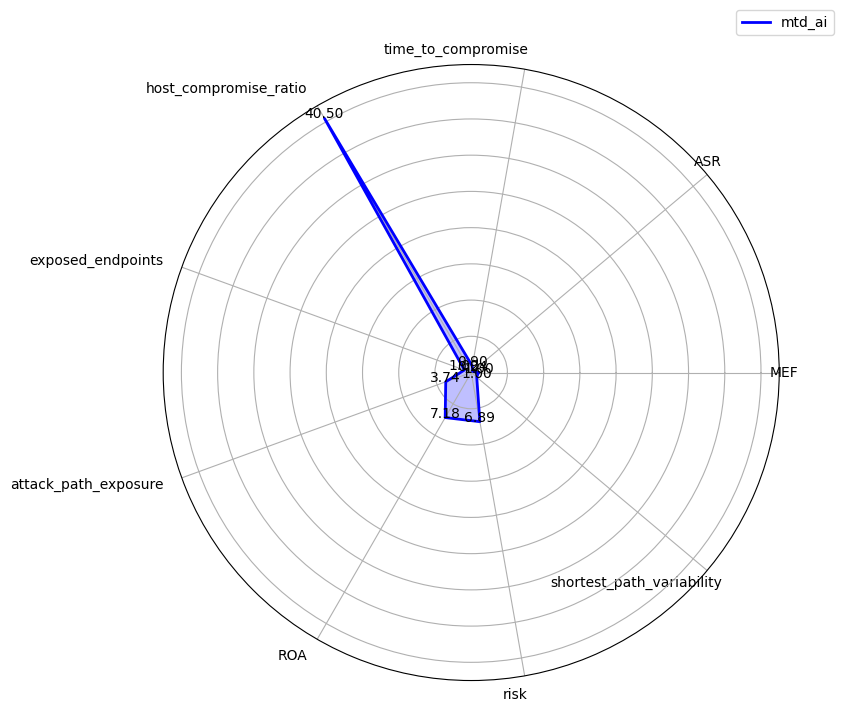

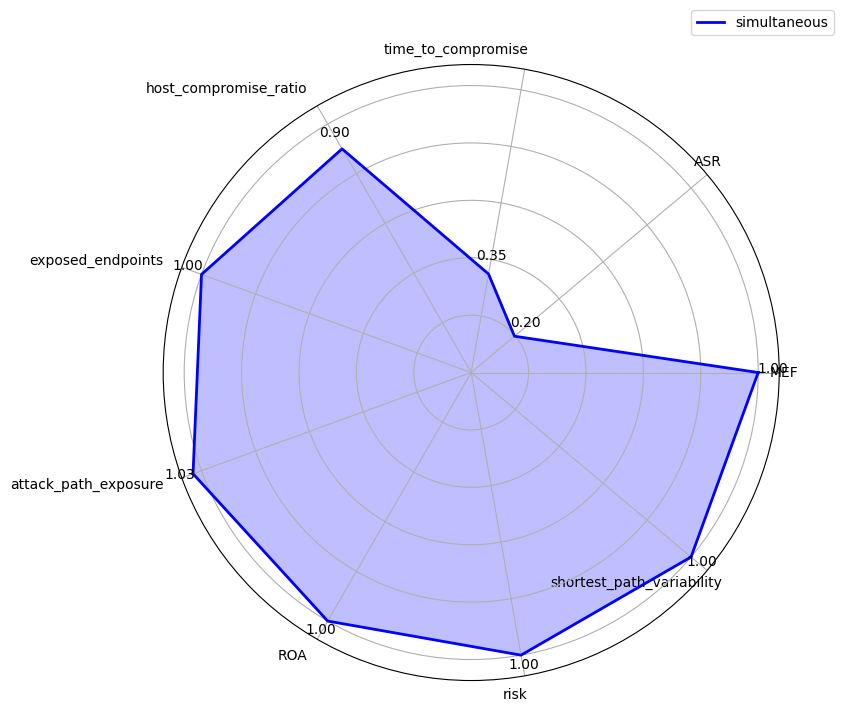

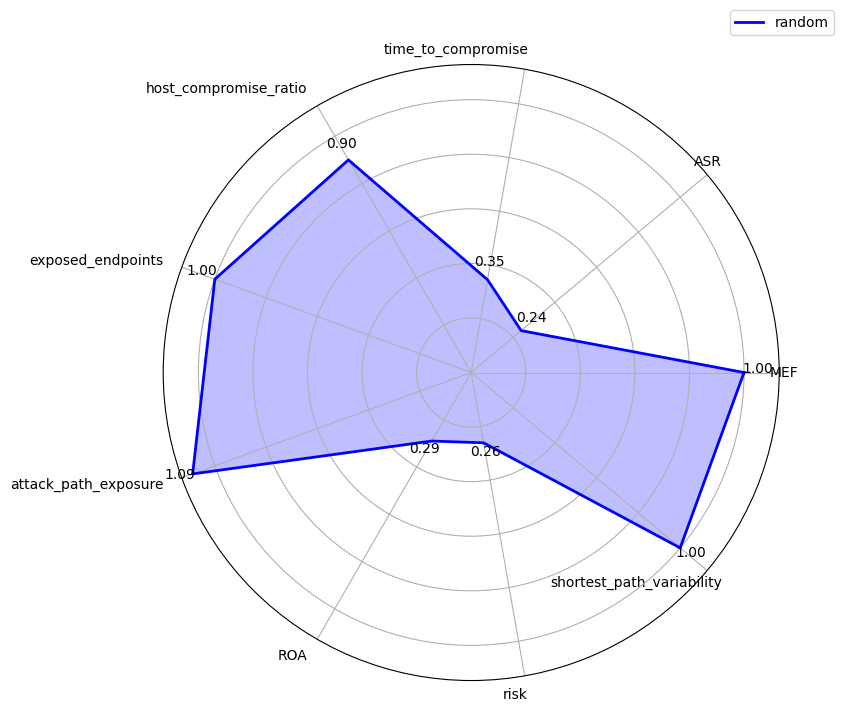

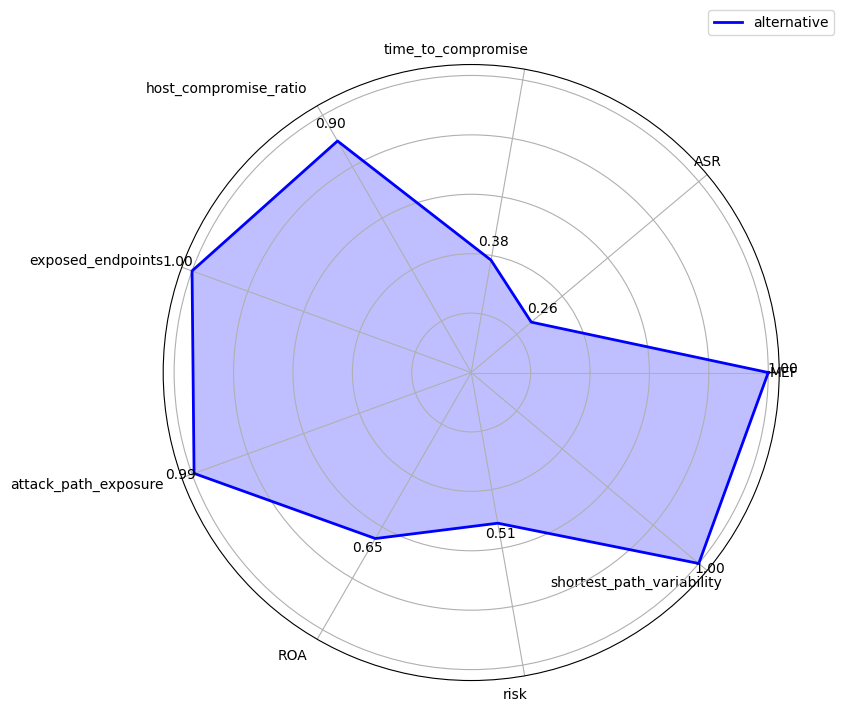

In [9]:
for scheme, data in results.items():
    radar.plot_single_radar(data, scheme, std_dev_values=None)
   